In [1]:
import pandas as pd

import os
from datetime import datetime

from pandas.api.types import CategoricalDtype
import pylab as P

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm

import glob
import fnmatch

import collections
import re

import logging

from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('display.max_columns', 1800)
pd.set_option('display.width', 1800)

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
import datetime
%pylab inline
sns.set(style="darkgrid")
plt.style.use('ggplot')

box=os.getenv('BOX_LOC')

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib as mpl


class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
mid_val=0


### Notebook for preparing a few control total files

[regional_controls.csv](https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/regional_controls.csv)

[county_employment_forecast.csv](https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv)

### Define a number of mappings 

In [3]:
INPUT_REMI_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output')
INPUT_BASEDATA_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/base_data')
INPUT_MAPPINGS_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/mappings')
OUTPUT_PATH = os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/output')

In [38]:
years_out=range(2010,2051,1)
years_out_5=range(2010,2051,5)

YEARS_OUT_1=range(2010,2051,1)
YEARS_OUT_1_2015=range(2015,2051,1)
YEARS_OUT_5=range(2010,2051,5)
YEARS_OUT_5_2015=range(2015,2051,5)


In [4]:
## geographic mappings

bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

counties_mtc={'Alameda':4,
 'Contra Costa':5,
 'Santa Clara':3,
 'Napa':7,
 'San Mateo':2,
 'San Francisco':1,
 'Sonoma':8,
 'Marin':9,
 'Solano':6}

## mapping for REMI area grouping
bayarearegions={'06001':'East Bay',
 '06013':'East Bay',
 '06085':'South Bay',
 '06055':'North Bay',
 '06081':'West Bay',
 '06075':'West Bay',
 '06097':'North Bay',
 '06041':'West Bay',
 '06095':'North Bay'}

pct=lambda x: x/x.sum()

In [5]:
## map remi occ groups to census major ones--this is dirty, bc the census ones shift.
occ_to_census = {u'Management, business, and financial occupations':'occ_mgmt',
u'Computer, mathematical, architecture, and engineering occupations':'occ_mgmt',
u'Life, physical, and social science occupations':'occ_mgmt',
u'Community and social service occupations':'occ_svcs',
u'Legal occupations':'occ_mgmt',
u'Education, training, and library occupations':'occ_svcs',
u'Arts, design, entertainment, sports, and media occupations':'occ_svcs',
u'Healthcare occupations':'occ_svcs',
u'Protective service occupations':'occ_svcs',
u'Food preparation and serving related occupations':'occ_sls',
u'Building and grounds cleaning and maintenance,personal care and service occupations':'occ_svcs',
u'Sales and related, office and administrative support occupations':'occ_sls',
u'Farming, fishing, and forestry occupations':'occ_nat',
u'Construction and extraction occupations':'occ_nat',
u'Installation, maintenance, and repair occupations':'occ_prod',
u'Production occupations':'occ_prod',
u'Transportation and material moving occupations':'occ_prod',
u'Military':'occ_other'}


In [6]:
## this table is custom generated in REMI--mxing in govt as industry employment

indus_to_census={u'State and Local Government':'ind_public',
u'Federal Civilian':'ind_public',
u'Federal Military':'ind_public',
u'Forestry, Fishing, and Related Activities':'ind_other',
u'Mining':'ind_other',
u'Utilities':'ind_other',
u'Construction':'ind_other',
u'Manufacturing':'ind_other',
u'Wholesale Trade':'ind_other',
u'Retail Trade':'ind_retail',
u'Transportation and Warehousing':'ind_other',
u'Information':'ind_prof',
u'Finance and Insurance':'ind_prof',
u'Real Estate and Rental and Leasing':'ind_prof',
u'Professional, Scientific, and Technical Services':'ind_prof',
u'Management of Companies and Enterprises':'ind_prof',
u'Administrative and Waste Management Services':'ind_other',
                 'Administrative, Support, Waste Management, And Remediation Services':'ind_other',
u'Educational Services':'ind_educ',
u'Educational Services; private':'ind_educ',
u'Health Care and Social Assistance':'ind_health',
u'Arts, Entertainment, and Recreation':'ind_other',
u'Accommodation and Food Services':'ind_accom_food_svcs',
u'Other Services, except Public Administration':'ind_other',
                u'Other Services':'ind_other'}

## mapping that collapses finer to coarser age bins in the remi output

agemapcollapser={u'Ages 0-15':u'Ages 0-15', u'Ages 16-19':u'Ages 16-19', u'Ages 20-21':u'Ages 20-24', u'Ages 22-24':u'Ages 20-24',
 u'Ages 25-29':u'Ages 25-34', u'Ages 30-34':u'Ages 25-34',
 u'Ages 35-44':u'Ages 35-44', u'Ages 45-54':u'Ages 45-54', u'Ages 55-59':u'Ages 55-64',
 u'Ages 60-61':u'Ages 55-64', u'Ages 62-64':u'Ages 55-64', u'Ages 65-69':u'Ages 65+', u'Ages 70-74':u'Ages 65+',
 u'Ages 75+':u'Ages 65+'}
set(agemapcollapser.values())

{u'Ages 0-15',
 u'Ages 16-19',
 u'Ages 20-24',
 u'Ages 25-34',
 u'Ages 35-44',
 u'Ages 45-54',
 u'Ages 55-64',
 u'Ages 65+'}

In [7]:
## mapping to SOC
occ_det_soc_map={'occ_det_mgmt':'11-0000',  ## mgmt
'occ_det_biz':'13-0000',   #  Business and Financial Operations Occupations
'occ_det_comp':'15-0000',   # Computer and Mathematical Occupations
'occ_det_community':'21-0000',  # Community and Social Service Occupations
'occ_det_lgl':'23-0000',  # legal
'occ_det_hlthsup':'31-0000',  # Healthcare Support Occupations
'occ_det_foodprep':'35-0000',  # Food Preparation and Serving Related Occupations
'occ_det_officeadmin':'43-0000'}#,  ## Office and Administrative Support Occupations

occ_det_soc_map={'11-0000': 'occ_det_mgmt',
 '13-0000': 'occ_det_biz',
 '15-0000': 'occ_det_comp',
 '21-0000': 'occ_det_community',
 '23-0000': 'occ_det_lgl',
 '31-0000': 'occ_det_hlthsup',
 '35-0000': 'occ_det_foodprep',
 '43-0000': 'occ_det_officeadmin'}

In [8]:
def trailing_zeros(longint):
    manipulandum = longint
    return len(manipulandum)-len(manipulandum.rstrip('0'))
def analyze_text(text):
    filtered = [c.lower() for c in text if c.isalpha()]
    #cnt = filtered.count('e')
    cnt=len(filtered)
    trail=trailing_zeros(text)
    
    if cnt>0:
        return cnt
    elif trail>0:
        return trail
    else:
        return 0
    
analyze_text('20xxxx'),analyze_text('533000')
analyze_text('113051')

0

In [9]:
def SOCP_format(s,precision=2):
    if not isinstance(s, float):
        start=s[0:2]
        middle=s[2:precision]
        end='0'*(6-precision)
        return start+'-'+middle+end
    else:
        return np.nan

In [10]:
## convenience label function
def agebreaker(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr}-{to}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels
#agebreaker(range(0,86,5))

def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

def agebreaker_mtc(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("age{fr:02}{to:02}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='age{dt:}p'.format(dt=breaks[-2])
    return labels
breaks_5 =range(0,86,5)+[np.inf]
#diffbreaks_5 =range(0,76,5)+[np.inf]

diffbreaks_custom =[0,5]+range(20,90,5)+[np.inf]
age_coarse=[0,5,15,25,65,inf]
age_mtc=[0,5,20,45,65,inf]


In [11]:
def rounder(s,precision=3):
    factor=10**precision
    out=np.round(s/10**precision,0)*factor
    return out

In [12]:
def classifier(df):
    """
    we need to classify each row with the appropriate hierarchy level.
    for each row, we want to get the rightmost value available--
    that represents the finest grained detail class
    """
    
    x = df.ix[:4].tolist()
    try:
        out = next(s for s in x if not s is np.NaN)
    except:
        out = None
    return  out

def classlevel(s):
    
    try:
        if s[3:]=='0000':
            return 'major'
        elif np.float64(s[3:]) % 100==0:
            return 'minor'
        elif np.float64(s[3:]) % 10==0:
            return 'broad'
        else:
            return 'detail'
    except:
        return 'none'

In [13]:
powlookup = pd.read_excel(os.path.join(INPUT_MAPPINGS_PATH,'ACSPUMS2015CodeLists.xls'),'POWPUMA-2015-lookup',skiprows=4)
powlookup.POWC=powlookup.POWC.apply(lambda x: '{:03.0f}'.format(x))
powlookup.POWSP=powlookup.POWSP.apply(lambda x: '{:03.0f}'.format(float(x)))
powlookup['POWSTPUMA']=powlookup.POWSP+powlookup.POWPUMA15

powlookup['STCOUNTY']=(powlookup.POWSP+powlookup.POWC).apply(lambda x: x[1:6])
powlookup=powlookup.groupby(['POWSTPUMA'])['STCOUNTY'].first()
#powlookup[powlookup['Detailed Area Name'].fillna('').str.contains('San Fran')]


In [14]:
{u'first-line enlisted military supervisors':'55-0000',
 u'counselors, social workers, and other community and social service specialists':'21-0000',
 u'military officer special and tactical operations leaders':'55-0000',
 u'military enlisted tactical operations and air/weapons specialists and crew members':'55-0000',
 u'tour and travel guides':'39-0000',
 u'baggage porters, bellhops, and concierges':'39-0000'}.values()

['39-0000', '55-0000', '55-0000', '39-0000', '21-0000', '55-0000']

In [15]:
{'Military Specific Occupations',
 u'baggage porters, bellhops, and concierges; tour and travel guides',
 u'counselors and social workers',
 u'miscellaneous community and social service specialists'}

{'Military Specific Occupations',
 u'baggage porters, bellhops, and concierges; tour and travel guides',
 u'counselors and social workers',
 u'miscellaneous community and social service specialists'}

In [16]:
soc = pd.read_excel(os.path.join(INPUT_MAPPINGS_PATH,'soc_structure_2010.xls'),skiprows=11,
                   names=[u'Major Group', u'Minor Group', u'Broad Group', u'Detailed Occupation', u'Description'])
soc['soc_2']=soc['Major Group']#.fillna('').str.split('-').apply(lambda x: x[0])

soc['class']=soc.ix[:,:4].apply(classifier,axis=1)
soc['hierarchy']=soc['class'].fillna('-1').map(classlevel)
soc['Description']=soc.Description.fillna('0').str.lower()
soc[soc.Description.fillna('').str.contains('chitect')]

soc=soc.append(pd.DataFrame(data={'Description':[u'baggage porters, bellhops, and concierges',
            u'baggage porters, bellhops, and concierges; tour and travel guides',
 u'military enlisted tactical operations and air/weapons specialists and crew members',
 u'first-line enlisted military supervisors',
 u'tour and travel guides',
 u'counselors, social workers, and other community and social service specialists',
                                                 u'counselors and social workers',
                                                  u'miscellaneous community and social service specialists',
 u'military officer special and tactical operations leaders',
                                                'military specific occupations'],
  'soc_2':['39-0000', '39-0000', '55-0000', '55-0000', '39-0000', '21-0000','21-0000', '21-0000','55-0000','55-0000'],
  'class':['39-0000','39-0000',  '55-0000', '55-0000', '39-0000', '21-0000','21-0000', '21-0000','55-0000','55-0000'],
    'hierarchy':['minor']*10}))

soc['soc_2']=soc['soc_2'].fillna(method='ffill')
soc=soc[soc['soc_2'].notnull()]
soc['DescShort']=soc.Description.str.slice(0,8)

## add occ names from remi files to SOC definition file so we can get occ code and then aggregate to a coarser level
# soc_to_add=pd.Series({u'first-line enlisted military supervisors':'55-0000',
#  u'counselors, social workers, and other community and social service specialists':'21-0000',
#  u'military officer special and tactical operations leaders':'55-0000',
#  u'military enlisted tactical operations and air/weapons specialists and crew members':'55-0000',
#  u'tour and travel guides':'39-0000',
#  u'baggage porters, bellhops, and concierges':'39-0000'},name='soc_2')
# soc_to_add=soc_to_add.reset_index().rename(columns={'index':'Description'})
# #soc=soc.append(soc_to_add)
# soc.loc[soc['class'].isnull(),'class']=soc.loc[soc['class'].isnull(),'soc_2']
# soc.loc[soc.Description.isin(soc_to_add.Description),['hierarchy']]='minor'
# soc.loc[soc.Description.isin(soc_to_add.Description),['class']]=soc.loc[soc.Description.isin(soc_to_add.Description),['soc_2']]

soc_minor=soc[soc.hierarchy=='minor'].set_index('Description')['class']


### Define dictionaries with scenarios to load
These are used to fetch raw REMI output from disk. Needless to say, they need to be pre-exported first.

In [17]:
BLUEPRINT_RUNS=['R6H2C_COVID_fix_rev2','R6H2C_COVID_cross_rev2']

In [21]:
scenarios=collections.OrderedDict([#('RC no change 3','RC no change 3'),
          # ('RC5','base_RC2050'),
          # ('R5H0C','H0_RC2050'),
          #  ('R5H1C','H1_RC2050'),
          #  ('R5H2C','H2_RC2050'),
            #('PBA_2040','PBA_2040'),
    
        ## draft blueprint    
        #('RC6','Blueprint Baseline'),
        #('R6H2C_fix','Blueprint Plus Fix it First'),
        #('R6H2C_plus','Blueprint Plus Crossing'),
        #('R6H2C_basic','Blueprint Basic'),

## draft blueprint, with COVID-19 adjustments    
('RC6_COVID_rev2','Blueprint-CV19 Baseline'),
('R6H2C_COVID_fix_rev2','Blueprint-CV19 Plus Fix it First'),
('R6H2C_COVID_cross_rev2','Blueprint-CV19 Plus Crossing'),
('R6H2C_COVID_basic_rev2','Blueprint-CV19 Basic')]
)

In [22]:
# scenarios_urbansim=collections.OrderedDict([
#  ('R5H2C','17: Forecast test, less constrained'),
#  ('R6H2C_basic','21: Blueprint Basic'),
#  ('R6H2C_fix','22: Blueprint Plus'),
#  ('R6H2C_plus','23: Blueprint Plus Crossing'),
#  ('RC5','16: Forecast test, base'),
#  ('RC6','20: No Project (Plan Bay Area 2050)')])

scenarios_urbansim=collections.OrderedDict([
 ('R5H2C','17: Forecast test, less constrained'),
 ('R6H2C_COVID_basic_rev2','21: Blueprint Basic'),
 ('R6H2C_COVID_fix_rev2','22: Blueprint Plus'),
 ('R6H2C_COVID_cross_rev2','23: Blueprint Plus Crossing'),
 ('RC5','16: Forecast test, base'),
 ('RC6_COVID_rev2','20: No Project (Plan Bay Area 2050)')])



scenarios_boxfoldermap={'R6H2C_COVID_basic_rev2':'Forecast 05052020/Blueprint Basic',
'R6H2C_COVID_fix_rev2':'Forecast 05052020/Blueprint Plus Fix it First',
'R6H2C_COVID_cross_rev2':'Forecast 05052020/Blueprint Crossing',
'RC5':'Draft Forecast Base Case',
'R5H2C':'Draft Forecast Upper Case',
'RC6_COVID_rev2':'Forecast 05052020/Blueprint Baseline'}


### Get PUMS 2015 data
We need this to get labor force occupation data by place of residence

In [23]:
#hh_sample_file='/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2010/ss101yrhca.csv'
person_sample_file='/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2015/ss151yrpca.csv'
#hh_sample=pd.read_csv(hh_sample_file)
persons=pd.read_csv(person_sample_file)

persons['YEAR']=2015

In [24]:
persons['STPUMA']=persons.ST.map(lambda x: '{:0>2}'.format(x))+persons.PUMA.map(lambda x: '{:0>5}'.format(x))
persons['STCOUNTY']=persons.STPUMA.str.slice(0,5)

persons['POWPUMA']=persons['POWPUMA'].apply(lambda x: '{:05.0f}'.format(x))
persons['POWSP']=persons['POWSP'].apply(lambda x: '{:03.0f}'.format(x))
persons['POWSTPUMA']=persons['POWSP']+persons['POWPUMA']
persons.loc[persons['POWSTPUMA'].str.contains('nan'),'POWSTPUMA']=np.nan

persons['POWSTCOUNTY']=persons.POWSTPUMA.map(powlookup)

persons['in_labor_force']=persons.ESR.isin(range(1,6)).map({True:'In Labor Force',False:'Not in Labor Force'})

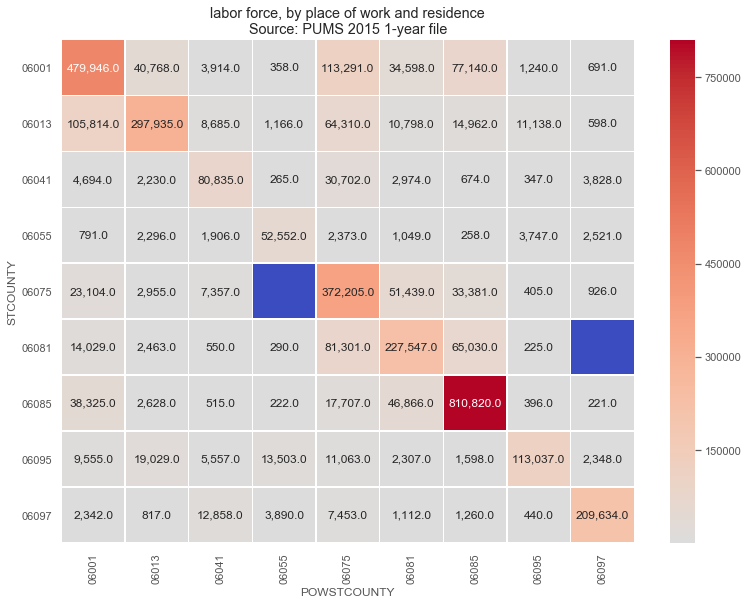

In [25]:
fig, ax = plt.subplots(figsize=[11,8.5])
    
sns.heatmap(persons.groupby(['POWSTCOUNTY','STCOUNTY']).PWGTP.sum().loc[bayareafips_full,bayareafips_full].unstack(0),
            annot=True, fmt=",.1f",linewidths=.5,norm=MidpointNormalize(midpoint=1),
            cmap=cm.coolwarm, annot_kws={"size": 12});
title('labor force, by place of work and residence\nSource: PUMS 2015 1-year file')#\nSource: Automation data from Frey & Osbourne 2017; Demographic data from ACS PUMS 2015-2017')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()


In [26]:
persons['county']=persons['county_name']=persons.STCOUNTY.map(bayareafips_full)

In [27]:
## flag records WRT available SOCP level detail 
persons['SOCP_level']=persons.SOCP.fillna('').map(analyze_text).map(lambda x: 6-x)
persons.loc[persons.SOCP.isnull(),'SOCP_level']=None
for i in range(2,7):
    persons['SOCP_%s'%i]=persons.SOCP.apply(SOCP_format,precision=i)

### Start preparing future RHS data / variables

#### Load REMI data
Updated, February 2020

Since remi 2.3, the export format is a bit different. We have mostly separate files, and mostly, for the big files, segmented by subregion.

Don't put junk files in these folders - we expect only the relevant output files to be there.

In [28]:
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'population')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))
outdata={}

for fn in matches:
    #print hdr['Forecast']
    #temp=pd.read_excel(matches[0],skiprows=5)

    temp=pd.read_excel(fn,skiprows=2)
    hdr=temp.iloc[0].to_dict()
    
    ## only load file if in scenarios dict defined above
    if hdr['Forecast'].strip() in scenarios:
        print "\tProcessing ",hdr['Forecast']#,hdr['Region']
    
        temp=pd.read_excel(fn,skiprows=5)
#        outdata[(scenarios[hdr['Forecast'].strip()],hdr['Region'].strip())]=temp.set_index(['Race','Gender','Ages']).filter(regex='\d{4}')
        outdata[hdr['Forecast'].strip()]=temp.set_index(['Region','Race','Gender','Ages']).filter(regex='\d{4}')

outdata=pd.concat(outdata)

outdata.index=outdata.index.set_names(['runid'],level=[0])
remipop=(outdata.stack()*1000).round(0).astype(np.int32).reset_index(name='value')

remipop=remipop.rename(columns={'Race':'rac_ethn','level_5':'Year'})
remipop['sex']=remipop.Gender.str.lower()
remipop['age_num']=remipop.Ages.str.extract('(\d{1,3})').astype(int)
remipop['age_fine']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(int),right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom)).astype(str)
remipop['age_grp_5']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=breaks_5,
           labels=agebreaker2(breaks_5),include_lowest=True,right=False)
remipop['age_grp_coarse']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=age_coarse,
           labels=agebreaker2(age_coarse),include_lowest=True,right=False)

remipop['age_grp_mtc']=pd.cut(remipop.Ages.str.extract('(\d{1,3})',expand=False).astype(np.int32),bins=age_mtc,
           labels=agebreaker_mtc(age_mtc),include_lowest=True,right=False)

remipop['gender']=remipop.Gender+'s'

	Processing  R6H2C_COVID_basic_rev2
	Processing  R6H2C_COVID_cross_rev2
	Processing  R6H2C_COVID_fix_rev2
	Processing  RC6_COVID_rev2


In [31]:
remipop['is_child']=remipop.age_num<18

In [32]:
futurepop=remipop.groupby(['runid','Region','Year']).value.sum().unstack('Year')

In [33]:
## create core demographic frames from which to extract specific series

remi_age=remipop.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()#.unstack('Year')
remi_race=remipop.groupby(['runid','Region','Year','rac_ethn']).value.sum()#.unstack('Year')

In [34]:
remipop.groupby(['runid','Year']).value.sum().loc[:,2018]

runid
R6H2C_COVID_basic_rev2    7801837
R6H2C_COVID_cross_rev2    7801837
R6H2C_COVID_fix_rev2      7801837
RC6_COVID_rev2            7801837
Name: value, dtype: int32

In [39]:
remipop.groupby(['runid','Year','is_child']).value.sum().groupby(level=[0,1]).apply(pct).loc[:,YEARS_OUT_5_2015].unstack('is_child')

is_child                        False     True 
runid                  Year                    
R6H2C_COVID_basic_rev2 2015  0.789664  0.210336
                       2020  0.798693  0.201307
                       2025  0.808171  0.191829
                       2030  0.817481  0.182519
                       2035  0.824510  0.175490
                       2040  0.826639  0.173361
                       2045  0.827626  0.172374
                       2050  0.828472  0.171528
R6H2C_COVID_cross_rev2 2015  0.789664  0.210336
                       2020  0.798693  0.201307
                       2025  0.808544  0.191456
                       2030  0.818015  0.181985
                       2035  0.825024  0.174976
                       2040  0.826981  0.173019
                       2045  0.827749  0.172251
                       2050  0.828418  0.171582
R6H2C_COVID_fix_rev2   2015  0.789664  0.210336
                       2020  0.798693  0.201307
                       2025  0.808552  0.191448
                       2030  0.818026  0.181974
                       2035  0.825031  0.174969
                       2040  0.826981  0.173019
                       2045  0.827747  0.172253
                       2050  0.828415  0.171585
RC6_COVID_rev2         2015  0.789664  0.210336
                       2020  0.798745  0.201255
                       2025  0.809611  0.190389
                       2030  0.820223  0.179777
                       2035  0.828493  0.171507
                       2040  0.831473  0.168527
                       2045  0.832936  0.167064
                       2050  0.833921  0.166079

#### Load labor force frames

In [40]:

matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'labor')):
    for filename in fnmatch.filter(filenames, 'lfpr_gender*.xlsx'):
        matches.append(os.path.join(root, filename))

outlfpr={}
for fn in matches:
    scen=fn.split('/')[-2]
    
    ## only load file if in scenarios dict defined above
    this_scen=fn.split(os.path.sep)[-2]
    if this_scen in scenarios:
        tmplfpr=pd.read_excel(fn,sheet_name='All',skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outlfpr[scen]=tmplfpr

outlfpr=pd.concat(outlfpr,names=['runid']).reset_index(1,drop=True).reset_index()
#rv_S_lf_female=outlfpr[outlfpr.Gender=='Female'].set_index(['runid','Region']).filter(regex='\d{4}')

#rv_S_lf=outlfpr[outlfpr.Gender=='Total'].set_index(['runid','Region']).filter(regex='\d{4}')

#### Load labor force data

In [41]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'labortot')):
    for filename in fnmatch.filter(filenames, '*.xlsx'):
        matches.append(os.path.join(root, filename))

outlf={}
for fn in matches:
    #scen=fn.split('/')[-2]
    
    ## only load file if in scenarios dict defined above
    this_scen=fn.split(os.path.sep)[-2]
    if this_scen in scenarios:
        print fn, scen
        tmplf=pd.read_excel(fn,skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outlf[this_scen]=tmplf

outlf=pd.concat(outlf,names=['runid']).reset_index(1,drop=True).reset_index()
## this file ships with Standard Regional Control as well - we don't want to double count
#outlf=outlf[outlf.Forecast!='Standard Regional Control']

/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_basic_rev2/hhinc 2 labor_age.xlsx RC6_COVID_rev2
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_cross_rev2/hhinc 2 labor_age.xlsx RC6_COVID_rev2
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/R6H2C_COVID_fix_rev2/hhinc 2 labor_age.xlsx RC6_COVID_rev2
/Users/aolsen/Box/Modeling and Surveys/Regional Modeling/REMI/REMI_raw_output/labortot/RC6_COVID_rev2/hhinc 2 labor_age.xlsx RC6_COVID_rev2


In [42]:
## main use is for EMPRES variable for topsheet later
outlf_df=(outlf.set_index(['runid','Region','Ages','Race','Gender']).filter(regex='\d{4}').stack()*1000).reset_index(name='value')
outlf_df=outlf_df.loc[outlf_df.Region.isin(['West Bay','East Bay','North Bay','South Bay'])].rename(columns={'level_5':'year'})

#### Load industry and occupation frames

In [43]:
## read Mike's occ mapping file. 
## Note that SOC 29 is split: Doctors are in "professional", the remainder in "services"

mike_occ_codes=pd.read_csv(os.path.join(INPUT_MAPPINGS_PATH,'emp_occ_codes.csv'),index_col=['Variable','Description']).SOC_codes
mike_occ_codes=mike_occ_codes.str.split(',').apply(pd.Series).stack().reset_index(2,drop=True).str.strip()
mike_occ_codes.head()

Variable              Description          
shr_occ_management    Management Occupation    11
                      Management Occupation    13
shr_occ_professional  Professional             15
                      Professional             17
                      Professional             19
dtype: object

#### Get county-level occupation data

In [44]:
import fnmatch
matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'indus_occup')):
    for filename in fnmatch.filter(filenames, 'B4b*'):
        matches.append(os.path.join(root, filename))


outocc_cnty=[]
outindus_cnty=[]
for fn in matches:
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
    
        tmpocc=pd.read_excel(fn,sheet_name='Occupations',skiprows=4)
        tmpind=pd.read_excel(fn,sheet_name='Employment by Industry',skiprows=4)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outocc_cnty.append(tmpocc[tmpocc.Forecast==this_scen])
        outindus_cnty.append(tmpind[tmpind.Forecast==this_scen])

outocc_cnty=pd.concat(outocc_cnty)
outindus_cnty=pd.concat(outindus_cnty)

In [45]:
## For ## https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv

outocc_cnty.loc[~outocc_cnty.Occupations.str.match(r'\s+'),'major_group']=outocc_cnty.loc[~outocc_cnty.Occupations.str.match(r'\s+')].Occupations
outocc_cnty['soc_minor']=outocc_cnty.Occupations.str.lower().str.strip().map(soc_minor.groupby(level=0).first())
outocc_cnty['SOCP_2']=outocc_cnty['soc_major']=outocc_cnty.soc_minor.str.slice(0,2)+'-0000'
outocc_cnty['county_name']=outocc_cnty.Region

## the detail occupations have whitespace in front. We use that for classification purposes
outocc_cnty['description']=outocc_cnty.Occupations.str.strip().str.lower()
outocc_cnty.loc[outocc_cnty.Occupations.str.match(r'\s+'),'detail']=outocc_cnty.loc[outocc_cnty.Occupations.str.match(r'\s+')].Occupations.str.strip()

## drop major groups (which are the REMI headings, but different than soc-2). Drop except military 
## as all other have components. Keep military as it has no children.

outocc_cnty=outocc_cnty.loc[(outocc_cnty.major_group.isnull())|(outocc_cnty.major_group=='Military')]
outocc_cnty.loc[(outocc_cnty.major_group=='Military'),['SOCP_2','soc_major','soc_minor','detail','description']]=['55-0000','55-0000','55-1000','military specific occupations','military specific occupations']
outocc_cnty.head(2)

,Forecast,Region,Occupations,Units,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,major_group,soc_minor,SOCP_2,soc_major,county_name,description,detail
1,R6H2C_COVID_basic_rev2,Alameda,Top executives,Thousands (Jobs),17.664824,17.298937,17.388119,17.531322,17.671785,17.921457,18.245531,18.194441,17.402145,17.155642,17.657393,18.362886,18.848665,19.420450,20.285128,20.773438,21.227705,21.840011,22.266008,20.804322,20.853523,21.224632,21.120516,21.067240,21.086162,21.504691,21.928974,22.457869,23.025175,23.653681,23.860362,24.018268,24.191081,24.384566,24.594616,24.811398,25.032519,25.259976,25.489753,25.721405,25.902456,26.086161,26.272366,26.463224,26.657594,26.851585,27.048647,27.244948,27.44305,27.625762,NaN,11-1000,11-0000,11-0000,Alameda,top executives,Top executives
2,R6H2C_COVID_basic_rev2,Alameda,"Advertising, marketing, promotions, public...",Thousands (Jobs),5.020119,4.839607,4.815718,4.801607,4.828212,4.859647,4.951555,5.030089,4.913181,4.783415,5.059286,5.259596,5.325519,5.388824,5.618851,5.807494,5.990941,6.180000,6.326688,5.943403,5.933202,5.968126,5.935942,5.920591,5.926210,6.073586,6.216450,6.385087,6.568242,6.765486,6.832221,6.886397,6.943764,7.005832,7.071952,7.140304,7.210361,7.282185,7.354725,7.427792,7.492805,7.558435,7.624675,7.692107,7.760499,7.828836,7.898052,7.967238,8.03697,8.102451,NaN,11-2000,11-0000,11-0000,Alameda,"advertising, marketing, promotions, public rel...","Advertising, marketing, promotions, public rel..."


In [46]:
# remi_undefined=filter(lambda x: 'occupations' not in x,set(soc[soc.hierarchy.isin(['major','minor'])].Description)-set(outocc_cnty.description))
# remi_undefined

### Occupation jobs to empres interlude
Since REMI has occupation detail only by place of work and not as a feature of the labor force, and since it ships in BEA equivalent, we scale the occupational counts at the county level to a labor force equivalent using exisiting 2015 ratios derived from PUMS. This could distort totals, but we just report shares, so it seems ok for now.

In [47]:
outocc_cnty_2015_soc2=(outocc_cnty.set_index(['Forecast','Region','soc_major'])[2015].loc['R6H2C_COVID_basic_rev2']*1000).round(0).astype(np.int32).sum(level=['Region','soc_major'])
outocc_cnty_2015_soc2.index=outocc_cnty_2015_soc2.index.set_names(['county_name','SOCP_2'])

occdist_comparative=pd.concat([persons[persons.in_labor_force=='In Labor Force'].groupby(['county_name','SOCP_2']).PWGTP.sum(),
           outocc_cnty_2015_soc2.sum(level=['county_name','SOCP_2'])],keys=['PUMS','REMI']).unstack(0).dropna().stack()
occdist_comparative_pct=occdist_comparative.groupby(level=0).apply(pct)
occdist_comparative_diff=occdist_comparative_pct.loc[:,:,'REMI']-occdist_comparative_pct.loc[:,:,'PUMS']
occdist_comparative_ratio=occdist_comparative_pct.loc[:,:,'REMI']/occdist_comparative_pct.loc[:,:,'PUMS']

In [48]:
REMI_POW_to_PUMS_POR_by_SOC_2=(outocc_cnty_2015_soc2/persons.groupby(['county_name','SOCP_2']).PWGTP.sum()).dropna()
REMI_POW_to_PUMS_POR_by_SOC_2.unstack(1)

#soc.loc[soc['Minor Group'].fillna('').str.contains('17-2000')]

SOCP_2,11-0000,13-0000,15-0000,17-0000,19-0000,21-0000,23-0000,25-0000,27-0000,29-0000,31-0000,33-0000,35-0000,37-0000,39-0000,41-0000,43-0000,45-0000,47-0000,49-0000,51-0000,53-0000,55-0000
county_name,,,,,,,,,,,,,,,,,,,,,,,
Alameda,0.530556,0.984070,0.523006,0.775729,0.439988,0.809053,0.755179,1.016375,0.642478,0.935487,1.290555,1.308529,1.388278,0.995987,1.032301,1.076582,1.388599,0.627839,1.036224,1.609846,1.550966,1.454572,4.172228
Contra Costa,0.377878,0.800179,0.667566,0.722955,0.521739,0.616133,0.547502,0.699526,0.361710,0.798548,1.128960,0.748611,1.267957,0.774048,0.929441,0.802644,1.077716,0.595588,0.666450,1.927204,0.795291,0.973313,2.485273
Marin,0.470967,1.114610,1.267613,2.174927,0.696765,0.954726,0.615722,1.145498,0.393566,0.856984,5.379882,1.767910,2.275627,1.154478,1.475736,0.901831,1.673594,2.216450,2.050052,4.314144,1.749623,2.251212,1.279070
Napa,0.628429,1.036672,2.617936,1.825127,1.261803,0.813387,1.152778,0.979163,0.541902,0.743223,1.226867,1.014882,1.779349,1.516714,1.298075,1.201911,1.607279,0.957336,1.029302,1.834297,1.317064,2.383540,NaN
San Francisco,0.638481,1.564441,1.150923,1.737358,0.944873,1.528280,1.065922,1.765059,0.789062,1.275538,2.899242,2.582989,2.009990,1.903191,1.267148,1.306676,2.762076,1.246231,1.331040,4.905929,1.384710,2.201092,14.333333
San Mateo,0.535320,1.197929,1.122856,1.303238,0.489808,1.325341,0.886496,0.726967,0.862315,0.704518,1.290620,1.086022,1.431829,1.108167,1.252019,0.994036,1.531242,0.895222,1.382364,2.259463,1.534837,1.926285,4.773234
Santa Clara,0.576480,1.323004,0.735763,0.842905,0.769376,1.196371,1.387989,0.990536,1.149592,1.085412,1.446448,1.290810,1.481744,1.141851,0.974866,1.167137,1.750281,0.670107,1.065612,2.071833,1.676463,1.761318,10.550000
Solano,0.478990,0.865272,0.705536,0.715692,0.789167,0.997563,0.539533,0.800419,0.547006,0.713651,0.868625,0.479208,1.207849,0.568180,0.711167,0.842457,0.742708,0.588868,0.526558,1.250507,0.731223,0.688689,1.834276
Sonoma,0.480353,1.125460,1.299625,0.641329,0.858613,0.929250,1.037364,0.840107,0.425419,0.968263,0.948516,1.404182,1.037664,0.970206,0.922182,0.972031,1.248989,0.579885,0.715296,1.730482,1.222272,1.112913,1.613349


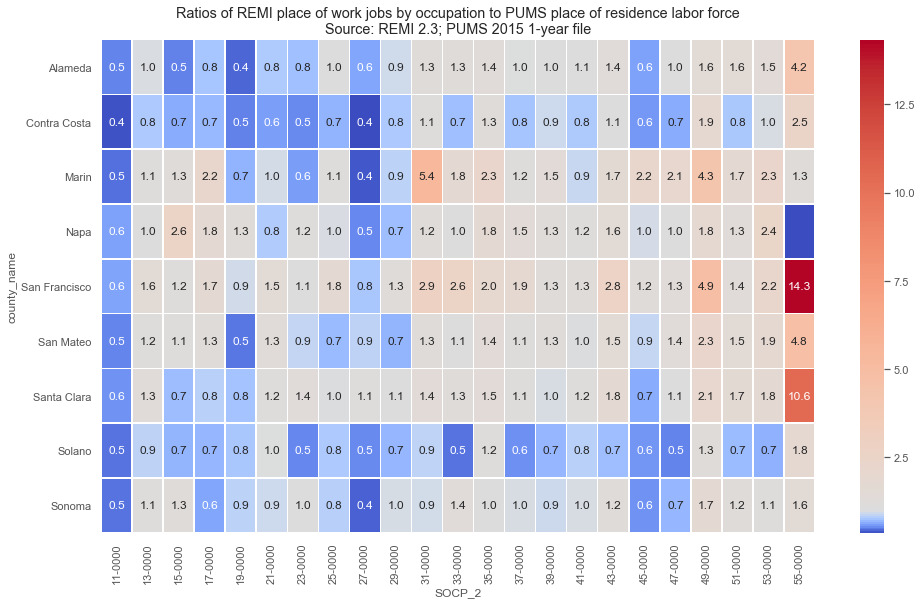

In [49]:
fig, ax = plt.subplots(figsize=[14,8.5])
    
sns.heatmap(REMI_POW_to_PUMS_POR_by_SOC_2.unstack(1),
            annot=True, fmt=",.1f",linewidths=.5,norm=MidpointNormalize(midpoint=1),
            cmap=cm.coolwarm, annot_kws={"size": 12});
title('Ratios of REMI place of work jobs by occupation to PUMS place of residence labor force\nSource: REMI 2.3; PUMS 2015 1-year file')#\nSource: Automation data from Frey & Osbourne 2017; Demographic data from ACS PUMS 2015-2017')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

In [50]:
## drop summary level
#outocc_cnty=outocc_cnty[outocc_cnty.detail.notna()]

## add mike's codes
outocc_cnty['occ_urbsim']=outocc_cnty.soc_minor.str.slice(0,2).map(mike_occ_codes.reset_index(name='value').groupby('value').Variable.first())
outocc_cnty.loc[outocc_cnty.Occupations.str.contains('Milit'),'occ_urbsim']='shr_occ_military'

## override non-docs for SOC 29 as services
outocc_cnty.loc[~(outocc_cnty.detail.fillna('').str.contains('Health diagnosing and treating practitioners'))
               &(outocc_cnty.fillna('').soc_minor=='29-0000'),'occ_urbsim']='shr_occ_services'

outocc_cnty['county']=outocc_cnty.Region.map(counties_mtc)
outocc_cnty=outocc_cnty[outocc_cnty.occ_urbsim.notna()]


## place of work summary
outocc_cnty_pct=outocc_cnty.groupby(['Forecast','county','Region','occ_urbsim']).sum().stack().groupby(level=['Forecast','county','Region',4]).apply(pct)
outocc_cnty_pct=outocc_cnty_pct.unstack('occ_urbsim').reset_index().rename(columns={'Region':'county_name','Forecast':'runid','level_3':'year'})
outocc_cnty_pct.head()

occ_urbsim,runid,county,county_name,year,shr_occ_management,shr_occ_manual,shr_occ_military,shr_occ_professional,shr_occ_retail,shr_occ_services
0,R6H2C_COVID_basic_rev2,1,San Francisco,2001,0.147817,0.252721,0.002308,0.175778,0.166411,0.254964
1,R6H2C_COVID_basic_rev2,1,San Francisco,2002,0.144332,0.255761,0.002409,0.178124,0.166551,0.252823
2,R6H2C_COVID_basic_rev2,1,San Francisco,2003,0.141886,0.256845,0.002472,0.179061,0.169208,0.250528
3,R6H2C_COVID_basic_rev2,1,San Francisco,2004,0.142324,0.253576,0.002415,0.181655,0.171173,0.248856
4,R6H2C_COVID_basic_rev2,1,San Francisco,2005,0.142018,0.253101,0.002289,0.183435,0.171963,0.247194


#### Scale place of work to place of res counts

In [51]:
outocc_cnty_for_scaling=outocc_cnty.groupby(['Forecast','county_name','SOCP_2','occ_urbsim']).sum().stack().unstack(['Forecast',4])

In [52]:
outocc_cnty_scaled=outocc_cnty_for_scaling.div(occdist_comparative_ratio,axis=0).stack([0,1]).sum(level=['Forecast','county_name','occ_urbsim',4])
outocc_cnty_scaled_pct=outocc_cnty_scaled.groupby(level=['Forecast','county_name',3]).apply(pct).unstack('occ_urbsim')
outocc_cnty_scaled_pct.loc(0)[:,'San Francisco',2015]

,,occ_urbsim,shr_occ_management,shr_occ_manual,shr_occ_military,shr_occ_professional,shr_occ_retail,shr_occ_services
Forecast,county_name,,,,,,,
R6H2C_COVID_basic_rev2,San Francisco,2015,0.247415,0.188563,NaN,0.238137,0.160552,0.165333
R6H2C_COVID_cross_rev2,San Francisco,2015,0.247415,0.188563,NaN,0.238137,0.160552,0.165333
R6H2C_COVID_fix_rev2,San Francisco,2015,0.247415,0.188563,NaN,0.238137,0.160552,0.165333
RC6_COVID_rev2,San Francisco,2015,0.247415,0.188563,NaN,0.238137,0.160552,0.165333


In [53]:
## Load misc income output - also not currently needed

matches = []
for root, dirnames, filenames in os.walk(os.path.join(INPUT_REMI_PATH,'income')):
    for filename in fnmatch.filter(filenames, 'misc income.xlsx'):
        matches.append(os.path.join(root, filename))


outincome=[]

for fn in matches:
    
    this_scen=fn.split('/')[-2]
    if this_scen in scenarios:
        print this_scen
        tmp=pd.read_excel(fn,skiprows=5)
        ## append scenario consistent with pathname only (file also has comparison / reference scenario - omit here)
        outincome.append(tmp[tmp.Forecast==this_scen])

outincome=pd.concat(outincome).set_index(['Forecast','Region','Category','Units']).filter(regex='\d{4}')

## turn into true values
outincome.loc(0)[:,:,:,'Thousands']*=1000
outincome.loc(0)[:,:,:,'Billions of Fixed (2009) Dollars']*=1e9

R6H2C_COVID_basic_rev2
R6H2C_COVID_cross_rev2
R6H2C_COVID_fix_rev2
RC6_COVID_rev2


In [54]:

real_pers_inc=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)

real_pers_inc_per_cap=outincome.loc(0)[:,:,'Personal Income'].reset_index(level=['Category','Units'],drop=True)/\
outincome.loc(0)[:,:,'Total Population'].reset_index(level=['Category','Units'],drop=True)
real_pers_inc_per_cap.head(2)

2001          2002          2003          2004          2005          2006          2007          2008          2009          2010          2011          2012          2013          2014          2015          2016          2017          2018          2019          2020          2021          2022          2023          2024          2025          2026          2027           2028           2029           2030           2031           2032           2033           2034           2035           2036           2037           2038           2039           2040           2041           2042           2043           2044           2045           2046           2047           2048           2049           2050
Forecast               Region                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
R6H2C_COVID_basic_rev2 West Bay   64159.710436  60598.292136  60339.940873  63159.318210  67032.087782  72034.664526  72867.890432  70452.107454  66801.559002  67465.867308  70742.950982  75629.476897  74844.297319  79949.458081  86170.908058  88300.403571  91050.454114  93628.827589  95890.340298  88313.827614  90103.828425  91767.884691  92435.932236  93322.134406  94435.625343  97081.458341  99862.545280  103019.740202  106325.363543  109401.355846  110375.171089  111328.774743  112449.631229  113704.658746  115070.934141  116498.167740  117954.776742  119486.474009  121063.132423  122688.392807  124278.385302  126002.460943  127794.646525  129659.905333  131593.917947  133593.146905  135665.303099  137817.817311  140047.095683  142343.784711
                       South Bay  54475.173139  50818.688443  50418.228890  50708.358933  52095.132177  55416.481630  57271.577379  54689.834885  51212.760158  53486.318227  56371.201257  60515.706859  59243.681797  63045.183135  68395.976448  72123.656491  74917.163750  77477.590822  79829.566198  73935.791820  74966.566937  76428.336159  77147.402763  78182.634014  79479.548717  82277.426803  85070.148632   88330.317446   91691.321916   94815.419904   96090.301812   97173.937783   98405.598773   99698.445482  101069.714950  102475.746027  103886.062301  105317.591750  106766.587523  108237.291501  109680.967361  111199.013305  112766.575273  114392.279425  116081.413962  117837.356060  119664.210165  121551.618722  123505.601124  125520.997322

## Prep controls and outputs

In [55]:
#xlsdata=pd.ExcelWriter(os.path.join(output_path,'topsheet_{:%Y%m%d_%H_%M}.xlsx'.format(datetime.datetime.now())))

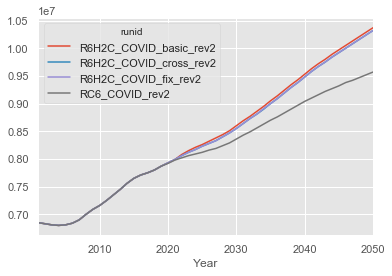

In [56]:
remipop.groupby(['runid','Year']).value.sum().apply(rounder,precision=4).unstack(0).plot()

In [57]:
## RACE

## create core demographic frames from which to extract specific series

remi_age=remipop.groupby(['runid','Region','Year','age_grp_coarse']).value.sum()#.unstack('Year')
remi_race=remipop.groupby(['runid','Region','Year','rac_ethn']).value.sum()#.unstack('Year')

remi_race.groupby(level=['runid','Year','rac_ethn']).sum().loc[:,YEARS_OUT_5].groupby(level=['runid','Year']).apply(pct).unstack('Year')#.to_excel(xlsdata,'race')
remi_age.groupby(level=['runid','Year','age_grp_coarse']).sum().loc[:,years_out].groupby(level=['runid','Year']).apply(pct).unstack('Year')#.to_excel(xlsdata,'age_grp_coarse')

remi_age.sum(level=[0,2]).loc[:,years_out].unstack(1)#.to_excel(xlsdata,'population')

Year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
runid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R6H2C_COVID_basic_rev2,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801837,7870732,7934725,7995986,8082200,8150594,8210197,8268146,8326078,8382415,8446971,8518655,8600654,8690538,8779486,8867614,8958365,9051916,9146970,9243122,9340176,9438264,9536921,9630521,9720249,9806949,9891382,9974203,10055706,10136235,10215872,10294875,10373100
R6H2C_COVID_cross_rev2,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801837,7870732,7934725,7992130,8067521,8126870,8179068,8231265,8285063,8338511,8401186,8471751,8553250,8642856,8731481,8819330,8909698,9002950,9097611,9193514,9290413,9388387,9487004,9580699,9670623,9757516,9842197,9925208,10006992,10087777,10167678,10246976,10325405
R6H2C_COVID_fix_rev2,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801837,7870732,7934725,7992254,8067429,8126601,8178597,8230673,8284488,8337961,8400752,8471429,8553106,8642883,8731678,8819622,8910159,9003511,9098262,9194201,9291135,9389165,9487895,9581621,9671591,9758534,9843216,9926274,10007987,10088783,10168696,10247961,10326424
RC6_COVID_rev2,7167026,7255420,7354912,7459008,7562687,7655589,7716461,7756152,7801837,7870521,7928966,7982261,8025977,8062974,8096179,8127817,8162256,8199084,8244050,8297706,8361268,8431409,8499210,8564868,8631754,8700159,8768836,8837653,8906373,8975271,9044128,9107723,9167286,9223548,9277471,9329551,9380125,9429414,9477616,9524969,9571263


#### Prep median age from finely binned data

In [58]:
remipop_age_pct=remipop.groupby(['runid','Year','age_num']).value.sum().loc[:,years_out].groupby(level=[0,1]).apply(pct).unstack('age_num')
agepop_cumsum=remipop_age_pct.cumsum(axis=1)
agepop_cumsum.head(2)

age_num                           0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16        17        18        19        20        21        22        23        24       25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        94        95        96        97        98        99   100
runid                  Year                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
R6H2C_COVID_basic_rev2 2010  0.012253  0.024519  0.037240  0.049933  0.062449  0.075071  0.087640  0.100024  0.112037  0.124239  0.136452  0.148351  0.160255  0.172229  0.184229  0.196634  0.209264  0.221951  0.234634  0.246873  0.259512  0.271895  0.284452  0.297508  0.311201  0.32574  0.340232  0.355113  0.370212  0.385098  0.400776  0.415337  0.429753  0.444188  0.458375  0.473219  0.487619  0.502087  0.516818  0.532206  0.548471  0.563646  0.578292  0.592549  0.606998  0.622364  0.637824  0.653269  0.668389  0.683515  0.699061  0.713733  0.728337  0.742748  0.756759  0.770805  0.784136  0.797072  0.809427  0.821428  0.833563  0.845085  0.856278  0.867732  0.876525  0.885164  0.893235  0.901181  0.908168  0.914579  0.920818  0.926668  0.932290  0.937487  0.942419  0.947221  0.951614  0.955916  0.960036  0.964062  0.968041  0.971633  0.975093  0.978378  0.981462  0.984388  0.987072  0.989467  0.991604  0.993482  0.995027  0.996153  0.997116  0.997858  0.998462  0.998910  0.999266  0.999518  0.999696  0.999805  1.0
                       2011  0.012199  0.024314  0.036483  0.049088  0.061676  0.074265  0.086725  0.099149  0.111392  0.123273  0.135504  0.147585  0.159348  0.171102  0.182955  0.195022  0.207315  0.219836  0.232219  0.243953  0.256265  0.269044  0.281700  0.294765  0.308337  0.32251  0.337331  0.352031  0.367039  0.382257  0.397269  0.412926  0.427535  0.441875  0.456249  0.470448  0.485166  0.499419  0.513735  0.528318  0.543636  0.559657  0.574653  0.589137  0.603217  0.617589  0.632744  0.648044  0.663273  0.678182  0.693179  0.708474  0.722934  0.737301  0.751479  0.765320  0.779098  0.792202  0.804901  0.817013  0.828811  0.840688  0.851949  0.862885  0.874065  0.882694  0.891101  0.898981  0.906710  0.913524  0.919766  0.925842  0.931527  0.936981  0.942015  0.946790  0.951406  0.955628  0.959752  0.963702  0.967540  0.971313  0.974721  0.977959  0.981026  0.983888  0.986571  0.9890

In [59]:
interval_begin=np.arange(0,100)
interval_end=np.arange(1,101)-.001

In [60]:
## loop through percentiles of interest

percentiles=[.5]
percentiledata={}

for p in percentiles:
    agepop_cumsum['middle_bin_start']=agepop_cumsum.apply(lambda x: interval_begin[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_start_share']=agepop_cumsum.apply(lambda x: x[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['middle_bin_end']=agepop_cumsum.apply(lambda x: interval_end[np.searchsorted(x,p,side='left').min()-1],axis=1)
    agepop_cumsum['median']=agepop_cumsum.apply(lambda x: x.middle_bin_start+(p-x.middle_bin_start_share)*x.middle_bin_start,axis=1)
    #print agepop_cumsum['median'].head()
    topsheet_age=agepop_cumsum['median'].unstack(1)
    percentiledata['p_{:02.0f}'.format(p*100)]=topsheet_age
pop_age_medians=pd.concat(percentiledata,axis=0,names=['percentile']).stack().unstack([1,0])
pop_age_medians.head(2)

runid,R6H2C_COVID_basic_rev2,R6H2C_COVID_cross_rev2,R6H2C_COVID_fix_rev2,RC6_COVID_rev2
percentile,p_50,p_50,p_50,p_50
Year,,,,
2010,36.445706,36.445706,36.445706,36.445706
2011,37.021480,37.021480,37.021480,37.021480


Text(0.5,1,'Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

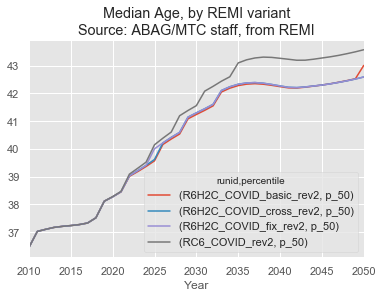

In [61]:
pop_age_medians.plot()
title('Median Age, by REMI variant\nSource: ABAG/MTC staff, from REMI')

In [67]:
#pop_age_medians.to_excel(xlsdata,'age_median')

In [68]:
## set general BEA to BLS scale factor

#BEA_SCALE=1.25

In [69]:
#(outocc.loc[(outocc.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','major_group']).sum().filter(regex='\d{4}').stack().loc[:,:,years_out].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_occup')

In [70]:
#(outindus.loc[(outindus.Region.isin(['East Bay','West Bay','North Bay','South Bay']))].groupby(['Forecast','indus_grp']).sum().filter(regex='\d{4}').stack().loc[:,:,years_out].unstack(2)*1e3/BEA_SCALE).round(0).astype(int64).to_excel(xlsdata,'emp_indus')

In [71]:
#xlsdata.close()

## Prepare control total dataframes

### A:  `regional_controls.csv` file


In [84]:
## target schema
controls_schema=['year','totpop','empres','medianage','age0004','age0519','age2044','age4564','age65p','st_res_vac']

In [85]:
controls_medianage=pop_age_medians.stack(level=[0,1]).reset_index('percentile',drop=True).reorder_levels(['runid','Year'])
controls_medianage.index=controls_medianage.index.set_names('year',level=1)
controls_medianage=controls_medianage.to_frame('medianage')
controls_medianage.head(2)

,,medianage
runid,year,
R6H2C_COVID_basic_rev2,2010,36.4457
R6H2C_COVID_cross_rev2,2010,36.4457


In [86]:
controls_empres=outlf_df.groupby(['runid','year']).value.sum().to_frame(name='empres')
controls_empres.head(2)

empres
runid                  year               
R6H2C_COVID_basic_rev2 2001 3,751,162.9957
                       2002 3,659,439.0042

In [87]:
controls_age=remipop.groupby(['runid','Year','age_grp_mtc']).value.sum().unstack('age_grp_mtc').loc(0)[:,years_out]
controls_age.index=controls_age.index.set_names('year',level=1)
controls_age.head()

age_grp_mtc                  age0004  age0519  age2044  age4564   age65p
runid                  year                                             
R6H2C_COVID_basic_rev2 2010   447576  1321767  2581031  1931701   884951
                       2011   447482  1322502  2606610  1965115   913711
                       2012   444148  1327335  2643536  1980046   959847
                       2013   442881  1333257  2681245  1999941  1001684
                       2014   442627  1335739  2720175  2020131  1044015

In [88]:
controls_pop=controls_age.sum(axis=1).to_frame(name='totpop')
controls_pop.index=controls_pop.index.set_names('year',level=1)
controls_pop.head(6)

totpop
runid                  year         
R6H2C_COVID_basic_rev2 2010  7167026
                       2011  7255420
                       2012  7354912
                       2013  7459008
                       2014  7562687
                       2015  7655589

In [89]:
pd.options.display.float_format = '{:,.4f}'.format
vac_acs=pd.read_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/household_forecast/base_data/acs_limited_vacancy_2018_2018.csv'),index_col=1).value

# controls_vacancy_rates=pd.concat([pd.Series(.017,index=range(2015,2020)),
#            pd.Series(np.linspace(start=.017,stop=.05,num=11),index=range(2020,2031)),
#            pd.Series(.05,index=range(2031,2051))])

## Extend vacancy rates into the future - converge at 2030 at 5%

controls_vacancy_rates=pd.concat([vac_acs[:-1],
           pd.Series(np.linspace(start=.0221,stop=.05,num=13),index=range(2018,2031)),
           pd.Series(.05,index=range(2031,2051))])

controls_vacancy_rates.index=controls_vacancy_rates.index.set_names('year')
controls_vacancy_rates.name='st_res_vac'
controls_vacancy_rates.head(12)

year
2010   0.0323
2011   0.0260
2012   0.0229
2013   0.0191
2014   0.0163
2015   0.0141
2016   0.0171
2017   0.0193
2018   0.0221
2019   0.0244
2020   0.0268
2021   0.0291
Name: st_res_vac, dtype: float64

In [105]:
regional_controls=pd.concat([controls_medianage,controls_pop,controls_empres,controls_age],axis=1).reorder_levels(['year','runid']).join(controls_vacancy_rates)
regional_controls=regional_controls.loc[years_out].reset_index()

regional_controls['scenario_urbansim']=regional_controls.runid.map(scenarios_urbansim)
regional_controls=regional_controls[regional_controls.runid.isin(scenarios_urbansim)]
regional_controls=regional_controls.set_index(['runid','scenario_urbansim']).loc[:,controls_schema]


regional_controls[[u'year', u'totpop', u'empres', u'age0004', u'age0519', u'age2044', u'age4564', u'age65p']]=regional_controls[[u'year', u'totpop', u'empres', u'age0004', u'age0519', u'age2044', u'age4564', u'age65p']].round(0).astype(int)
regional_controls.update(regional_controls[[u'medianage',u'st_res_vac' ]].round(3).astype(float))

regional_controls=regional_controls[regional_controls.year.isin(YEARS_OUT_5)]
regional_controls

year    totpop   empres  medianage  age0004  age0519  age2044  age4564   age65p  st_res_vac
runid                  scenario_urbansim                                                                                                               
R6H2C_COVID_basic_rev2 21: Blueprint Basic                  2010   7167026  3763886    36.4460   447576  1321767  2581031  1931701   884951      0.0320
                       21: Blueprint Basic                  2015   7655589  4040983    37.2330   443196  1336223  2750267  2039839  1086064      0.0140
                       21: Blueprint Basic                  2020   7934725  4212289    38.2680   423789  1364719  2791793  2081971  1272453      0.0270
                       21: Blueprint Basic                  2025   8268146  4295289    39.5650   412124  1376876  2851841  2136674  1490631      0.0380
                       21: Blueprint Basic                  2030   8600654  4489551    41.2350   404508  1366715  2877532  2243836  1708063      0.0500
                       21: Blueprint Basic                  2035   9051916  4727927    42.2770   420634  1379112  2940865  2425465  1885840      0.0500
                       21: Blueprint Basic                  2040   9536921  4978007    42.2390   449589  1411435  3079483  2564404  2032010      0.0500
                       21: Blueprint Basic                  2045   9974203  5212097    42.2960   466993  1461971  3254190  2616219  2174830      0.0500
                       21: Blueprint Basic                  2050  10373100  5433994    43.0030   473487  1520658  3336153  2678003  2364799      0.0500
R6H2C_COVID_cross_rev2 23: Blueprint Plus Crossing          2010   7167026  3763886    36.4460   447576  1321767  2581031  1931701   884951      0.0320
                       23: Blueprint Plus Crossing          2015   7655589  4040983    37.2330   443196  1336223  2750267  2039839  1086064      0.0140
                       23: Blueprint Plus Crossing          2020   7934725  4212289    38.2680   423789  1364719  2791793  2081971  1272453      0.0270
                       23: Blueprint Plus Crossing          2025   8231265  4279802    39.6150   408660  1369348  2831808  2131111  1490338      0.0380
                       23: Blueprint Plus Crossing          2030   8553250  4471524    41.2940   400753  1356185  2854000  2235494  1706818      0.0500
                       23: Blueprint Plus Crossing          2035   9002950  4711060    42.3250   417165  1368067  2919140  2415056  1883522      0.0500
                       23: Blueprint Plus Crossing          2040   9487004  4961578    42.2650   446848  1400672  3060044  2551098  2028342      0.0500
                       23: Blueprint Plus Crossing          2045   9925208  5196610    42.2970   465058  1452882  3238450  2599371  2169447      0.0500
                       23: Blueprint Plus Crossing          2050  10325405  5419492    42.5860   471807  1513456  3323310  2659388  2357444      0.0500
R6H2C_COVID_fix_rev2   22: Blueprint Plus                   2010   7167026  3763886    36.4460   447576  1321767  2581031  1931701   884951      0.0320
                       22: Blueprint Plus                   2015   7655589  4040983    37.2330   443196  1336223  2750267  2039839  1086064      0.0140
                       22: Blueprint Plus                   2020   7934725  4212289    38.2680   423789  1364719  2791793  2081971  1272453      0.0270
                       22: Blueprint Plus                   2025   8230673  4279725    40.0000   408567  1369245  2831506  2131025  1490330      0.0380
                       22: Blueprint Plus                   2030   8553106  4471777    41.2940   400706  1356122  2854005  2235467  1706806      0.0500
                       22: Blueprint Plus                   2035   9003511  4711616    42.3250   417173  1368109  2919567  2415147  1883515      0.0500
                       22: Blueprint Plus                   2040   9487895  4962232    42.2640   446910  140

In [114]:
## write to CSV files on box

for nme, dta in regional_controls.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/regional_controls_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(BAUS_DIR,'s{pth}/regional_controls_s{fl}.csv'.format(pth=nme[1][:2],fl=nme[1][:2])))
    

('R6H2C_COVID_basic_rev2', '21: Blueprint Basic')
('R6H2C_COVID_cross_rev2', '23: Blueprint Plus Crossing')
('R6H2C_COVID_fix_rev2', '22: Blueprint Plus')
('RC6_COVID_rev2', '20: No Project (Plan Bay Area 2050)')


### B: `county_employment_forecast.csv` file
https://github.com/BayAreaMetro/bayarea_urbansim/blob/master/data/county_employment_forecast.csv

In [92]:
## version has PLACE OF WORK shares

outocc_cnty_pct_df=outocc_cnty_pct.copy()
outocc_cnty_pct_df['scenario_urbansim']=outocc_cnty_pct_df.runid.map(scenarios_urbansim)

outocc_cnty_pct_df=outocc_cnty_pct_df[[u'runid', u'scenario_urbansim', u'county', u'county_name', u'year', u'shr_occ_management', u'shr_occ_manual', u'shr_occ_professional', u'shr_occ_retail', u'shr_occ_services','shr_occ_military']]
outocc_cnty_pct_df=outocc_cnty_pct_df.set_index([u'runid', u'scenario_urbansim', u'county', u'county_name', u'year'])
outocc_cnty_pct_df=outocc_cnty_pct_df.loc(0)[:,:,:,:,years_out_5].round(5)
outocc_cnty_pct_df.head()

occ_urbsim                                                            shr_occ_management  shr_occ_manual  shr_occ_professional  shr_occ_retail  shr_occ_services  shr_occ_military
runid                  scenario_urbansim   county county_name   year                                                                                                              
R6H2C_COVID_basic_rev2 21: Blueprint Basic 1      San Francisco 2010              0.1466          0.2429                0.1950          0.1684            0.2449            0.0024
                                                                2015              0.1505          0.2396                0.2041          0.1680            0.2360            0.0018
                                                                2020              0.1575          0.2398                0.2185          0.1507            0.2316            0.0019
                                                                2025              0.1551          0.2444                0.2140          0.1652            0.2195            0.0017
                                                                2030              0.1577          0.2416                0.2165          0.1654            0.2173            0.0015

In [118]:
for nme, dta in outocc_cnty_pct_df.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_employment_forecast_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(BAUS_DIR,'s{pth}/county_employment_forecast_s{fl}.csv'.format(pth=nme[1][:2],fl=nme[1][:2])))
## for now, there is an identical file that is also being used downstream

for nme, dta in outocc_cnty_pct_df.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_forecast_input_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(BAUS_DIR,'s{pth}/county_forecast_input_s{fl}.csv'.format(pth=nme[1][:2],fl=nme[1][:2])))

(u'R6H2C_COVID_basic_rev2', '21: Blueprint Basic')
(u'R6H2C_COVID_cross_rev2', '23: Blueprint Plus Crossing')
(u'R6H2C_COVID_fix_rev2', '22: Blueprint Plus')
(u'RC6_COVID_rev2', '20: No Project (Plan Bay Area 2050)')
(u'R6H2C_COVID_basic_rev2', '21: Blueprint Basic')
(u'R6H2C_COVID_cross_rev2', '23: Blueprint Plus Crossing')
(u'R6H2C_COVID_fix_rev2', '22: Blueprint Plus')
(u'RC6_COVID_rev2', '20: No Project (Plan Bay Area 2050)')


#### REMI occ data scaled to place of residence instead

Data frame processed earlier - this is just formating and saving.

In [101]:
outocc_cnty_scaled_pct_df=outocc_cnty_scaled_pct.reset_index().rename(columns={'Forecast':'runid','level_2':'year'})
outocc_cnty_scaled_pct_df['scenario_urbansim']=outocc_cnty_scaled_pct_df.runid.map(scenarios_urbansim)

outocc_cnty_scaled_pct_df['county']=outocc_cnty_scaled_pct_df['county_name'].map(counties_mtc)
outocc_cnty_scaled_pct_df=outocc_cnty_scaled_pct_df.set_index([u'runid', u'scenario_urbansim', u'county', u'county_name', u'year'])[[u'shr_occ_management', u'shr_occ_manual', u'shr_occ_professional', u'shr_occ_retail', u'shr_occ_services', u'shr_occ_military']]
outocc_cnty_scaled_pct_df=outocc_cnty_scaled_pct_df.loc(0)[:,:,:,:,years_out_5].round(5).fillna(0)
outocc_cnty_scaled_pct_df.head()

occ_urbsim                                                          shr_occ_management  shr_occ_manual  shr_occ_professional  shr_occ_retail  shr_occ_services  shr_occ_military
runid                  scenario_urbansim   county county_name year                                                                                                              
R6H2C_COVID_basic_rev2 21: Blueprint Basic 4      Alameda     2010              0.1771          0.2440                0.2473          0.1368            0.1936            0.0012
                                                              2015              0.1759          0.2582                0.2414          0.1371            0.1864            0.0011
                                                              2020              0.1789          0.2583                0.2559          0.1255            0.1803            0.0011
                                                              2025              0.1776          0.2618                0.2522          0.1339            0.1735            0.0010
                                                              2030              0.1789          0.2572                0.2552          0.1342            0.1735            0.0009

In [117]:
for nme, dta in outocc_cnty_scaled_pct_df.groupby(level=['runid','scenario_urbansim']):
    print nme
    dta.to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_employment_forecast_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    
    ## for now, there is an identical file that is also being used downstream
    dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(box,'Modeling and Surveys/Regional Modeling/REMI/REMI files/PBA50 Blueprint/REMI output/{pth}/county_forecast_input_s{fl}.csv'.format(pth=scenarios_boxfoldermap[nme[0]],fl=nme[1][:2])))
    #dta.reset_index(['runid','scenario_urbansim'],drop=True).to_csv(os.path.join(BAUS_DIR,'s{pth}/county_forecast_input_s{fl}.csv'.format(pth=nme[1][:2],fl=nme[1][:2])))

(u'R6H2C_COVID_basic_rev2', '21: Blueprint Basic')
(u'R6H2C_COVID_cross_rev2', '23: Blueprint Plus Crossing')
(u'R6H2C_COVID_fix_rev2', '22: Blueprint Plus')
(u'RC6_COVID_rev2', '20: No Project (Plan Bay Area 2050)')
